In [303]:
# Import dependencies
import pandas as pd
import scipy.stats as st
from scipy import optimize
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [304]:
# Prepare the dataset for analysis
# Read in csv file
file_path = "Conditions_Contributing_to_COVID-19_Deaths__by_State_and_Age__Provisional_2020-2023.csv"
inital_df = pd.read_csv(file_path)

# Drop the unwanted columns.
inital_df = inital_df.drop(columns=['Data As Of', 'Start Date', 'End Date', 'ICD10_codes', 'Number of Mentions', 'Flag'])

# Only keep the rows where the Group is "By Month", and delete the row where Age Group is "All Ages"
inital_df = inital_df.loc[inital_df['Group'] == 'By Month']
clean_df = inital_df.loc[inital_df['Age Group'] != 'All Ages']

# Drop the NaN values
clean_df = clean_df.dropna()

# Convert Year and Month columns to integers
clean_df.loc[:, 'Year'] = clean_df['Year'].astype(int)
clean_df.loc[:, 'Month'] = clean_df['Month'].astype(int)
clean_df.loc[:, 'COVID-19 Deaths'] = clean_df['COVID-19 Deaths'].astype(int)

clean_df.head()

,Group,Year,Month,State,Condition Group,Condition,Age Group,COVID-19 Deaths
62100,By Month,2020,1,United States,Respiratory diseases,Influenza and pneumonia,0-24,0
62101,By Month,2020,2,United States,Respiratory diseases,Influenza and pneumonia,0-24,0
62102,By Month,2020,3,United States,Respiratory diseases,Influenza and pneumonia,0-24,9
62103,By Month,2020,4,United States,Respiratory diseases,Influenza and pneumonia,0-24,27
62104,By Month,2020,5,United States,Respiratory diseases,Influenza and pneumonia,0-24,19


In [305]:
# Group Covid-19 deaths by year and month while keeping months in order
grouped_df = clean_df.groupby(['Year','State', 'Month'])['COVID-19 Deaths'].sum().reset_index()
grouped_df.sort_values(by=['Year', 'Month'])


# Group into seasons by defining a function to return the season based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"
# Apply the function to the dataframe and create a new column named "Season"    
grouped_df['Season'] = grouped_df['Month'].apply(get_season)

grouped_df


,Year,State,Month,COVID-19 Deaths,Season
0,2020,Alabama,1,0,Winter
1,2020,Alabama,2,0,Winter
2,2020,Alabama,3,24,Spring
3,2020,Alabama,4,851,Spring
4,2020,Alabama,5,1131,Spring
...,...,...,...,...,...
2101,2023,Wisconsin,2,370,Winter
2102,2023,Wisconsin,3,50,Spring
2103,2023,Wyoming,1,0,Winter
2104,2023,Wyoming,2,0,Winter


In [323]:


index_seasons = [3,1,2,0,7,5,6,4,11,9,10,8,13,12]

covid_seasons = grouped_df.reindex(index_seasons).reset_index(drop=True)
covid_seasons.rename(columns={'COVID-19 Deaths': 'Deaths'}, inplace=True)

def rename_seasons(season,year):
       season += [''] * (4 - len(season))
       return [f'{s} {year}' for s in season]
       
covid_years = covid_seasons['Year'].unique()
season_year = {}
for year in covid_years:
    seasons = covid_seasons.loc[covid_seasons['Year'] == year, 'Season'].tolist()
    season_year[year] = rename_seasons(seasons,year)

for year in covid_years:
    for i, season in enumerate(['Winter', 'Spring', 'Summer', 'Fall']):

        covid_seasons.loc[(covid_seasons['Year'] == year) & (covid_seasons['Season'] == season), 'Season'] = season_year[year][i]


print(covid_seasons)

    Year       Season   Deaths
0   2020  Winter 2020   731229
1   2020  Spring 2020   751464
2   2020  Summer 2020   571228
3   2020    Fall 2020   705529
4   2021  Winter 2021  1506198
5   2021  Spring 2021   410485
6   2021  Summer 2021   483637
7   2021    Fall 2021  1029730
8   2022  Winter 2022  1143007
9   2022  Spring 2022   209295
10  2022  Summer 2022   261869
11  2022    Fall 2022   214540
12  2023  Winter 2023   166846
13  2023  Spring 2023    12142


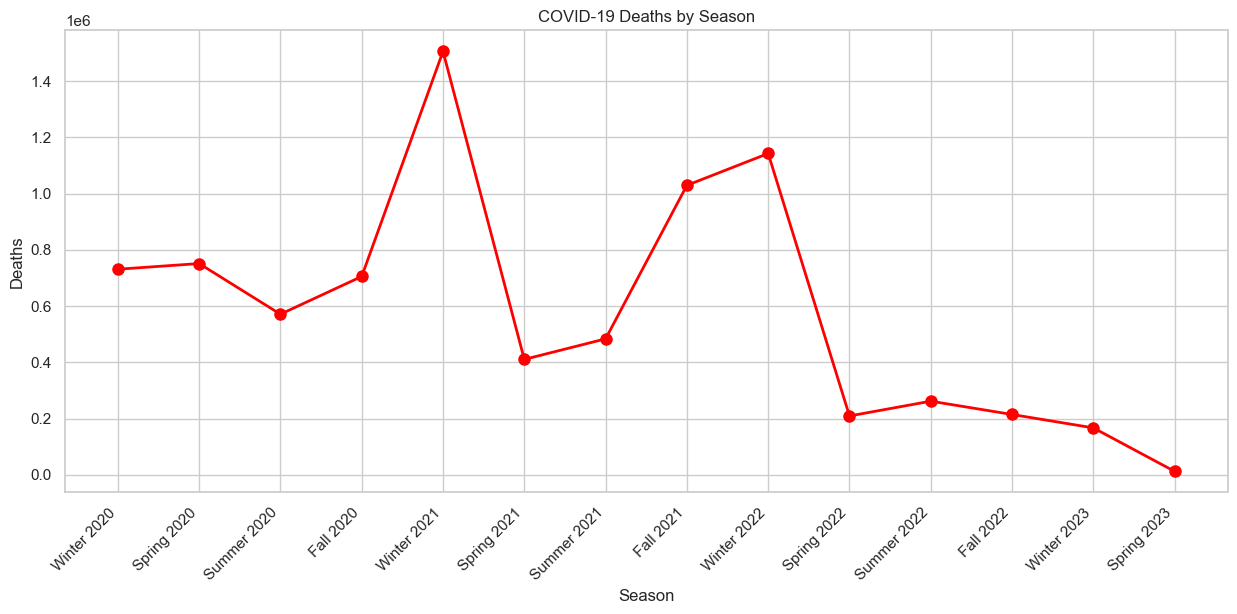

In [324]:

# Plot the data
plt.figure(figsize=(15, 6))
           
plt.plot(covid_seasons['Season'], covid_seasons['Deaths'], color='red', marker='o', linewidth=2, markersize=8)
plt.gca().set_xticks(covid_seasons.index)
plt.gca().set_xticklabels(covid_seasons['Season'], rotation=45, ha='right')

plt.title('COVID-19 Deaths by Season')
plt.xlabel('Season')
plt.ylabel('Deaths')

plt.show()

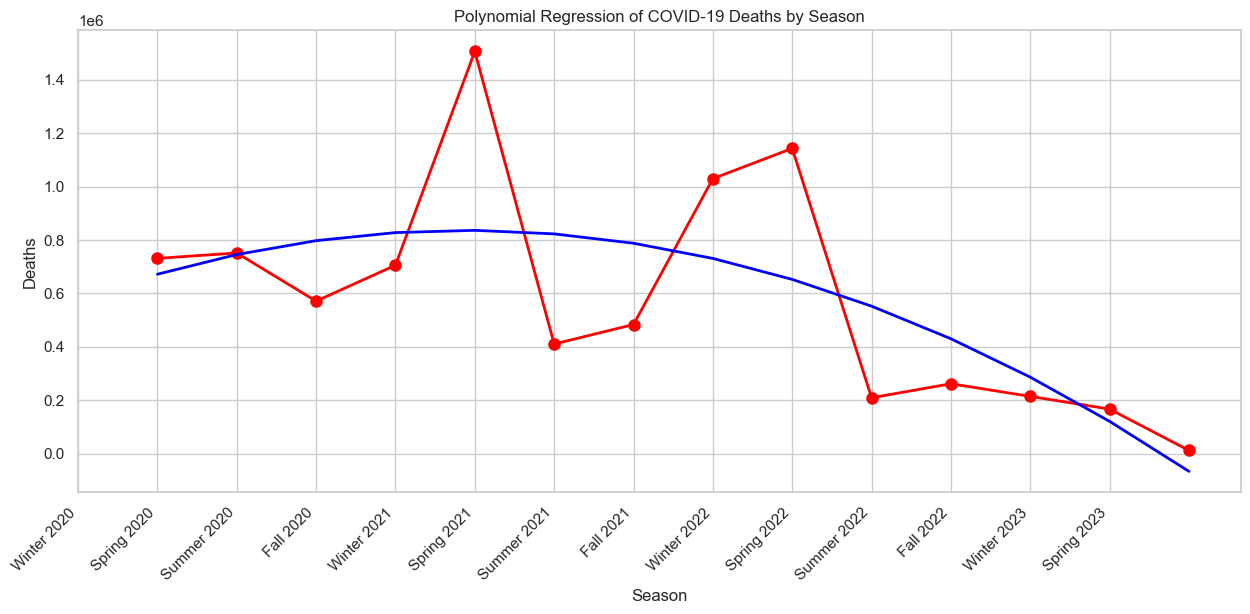

In [325]:
season_dict = {'Winter 2020': 1,
               'Spring 2020': 2,
               'Summer 2020': 3,
               'Fall 2020': 4,
               'Winter 2021': 5,
               'Spring 2021': 6,
               'Summer 2021': 7,
               'Fall 2021': 8,
               'Winter 2022': 9,
               'Spring 2022': 10,
               'Summer 2022': 11,
               'Fall 2022': 12,
               'Winter 2023': 13,
               'Spring 2023': 14,}

season = covid_seasons['Season']
deaths = covid_seasons['Deaths']

season_integer = [season_dict[s] for s in season]

poly = PolynomialFeatures(degree=2)
season_poly = poly.fit_transform(np.array(season_integer).reshape(-1, 1))
model = LinearRegression()
model.fit(season_poly, deaths)

plt.figure(figsize=(15, 6))
plt.plot(season_integer, deaths, color='red', marker='o',linewidth=2, markersize=8)
plt.plot(season_integer, model.predict(season_poly), color='blue', linewidth=2)
plt.gca().set_xticks(covid_seasons.index)
plt.gca().set_xticklabels(covid_seasons['Season'], rotation=45, ha='right')
plt.title('Polynomial Regression of COVID-19 Deaths by Season')
plt.xlabel('Season')
plt.ylabel('Deaths')
plt.show()

R-squared: 0.31
p-value: 0.04
std_err: 24319.56


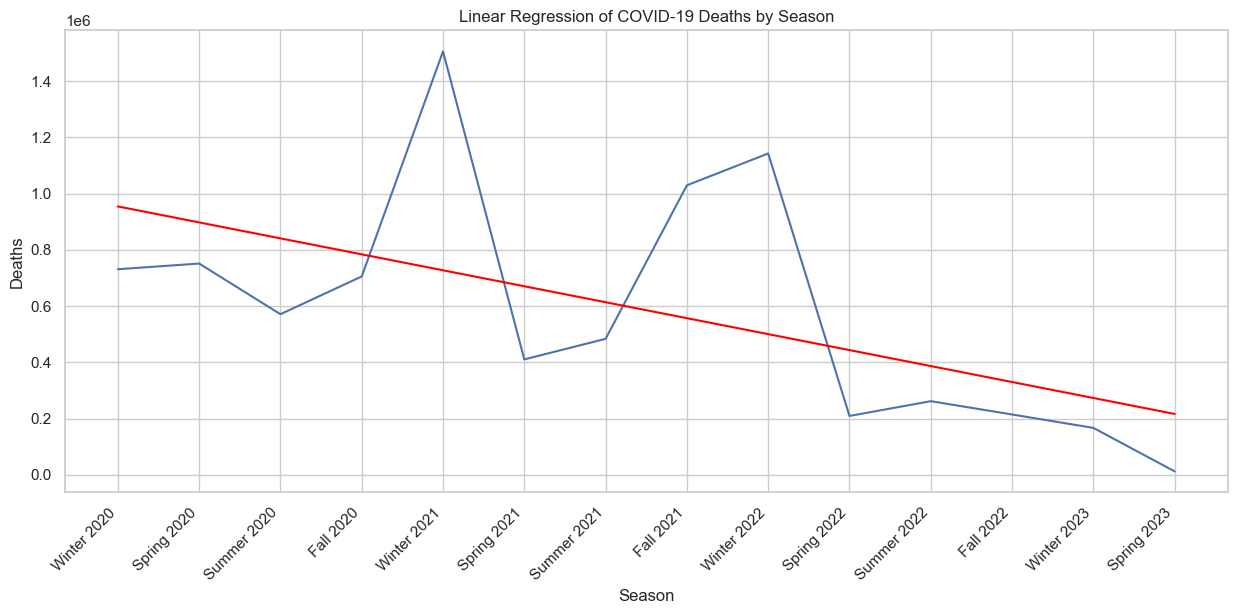

In [328]:


sns.set(style="whitegrid")
plt.subplots(figsize=(15, 6))
sns.lineplot(x="Season", y="Deaths", data=covid_seasons)

slope, intercept, r_value, p_value, std_err = st.linregress(covid_seasons.index, covid_seasons['Deaths'])
expected_values = [slope * i + intercept for i in covid_seasons.index]

sns.lineplot(x='Season', y=expected_values, data=covid_seasons, color='red')
plt.xticks(rotation=45, ha='right')
plt.title('Linear Regression of COVID-19 Deaths by Season')
plt.xlabel('Season')
plt.ylabel('Deaths')


rss = sum((covid_seasons['Deaths'] - expected_values) ** 2)
tss = sum((covid_seasons['Deaths'] - np.mean(covid_seasons['Deaths'])) ** 2)
r_squared = 1 - (rss / tss)

print(f'R-squared: {r_squared:.2f}')
print(f'p-value: {p_value:.2f}')
print(f'std_err: {std_err:.2f}')

plt.show()